# Using NN to study the Ising model phase transition

Notebook based on the paper:

**Machine learning phases of matter.** ([Link](http://arxiv.org/abs/1605.01735%0Ahttp://dx.doi.org/10.1038/nphys4035))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
import sys, os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [6.32, 5.11]
plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
path = '../Data/'

In [4]:
L = 40
temp_val = np.arange(0.25, 4.0001, 0.25)
temp_samples = 10000
total_samples = temp_samples * temp_val.shape[0]
test_size = 0.1
val_size = 0.2

In [5]:
split_tc = True

In [6]:
data = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All.pkl','rb'))
data = np.unpackbits(data).reshape(-1, L * L).astype(int)
data[np.where(data==0)]=-1

labels = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))

In [7]:
first_tc = np.where(temp_val <= 2.)[0][-1] * temp_samples
last_tc = np.where(temp_val >= 3)[0][1] * temp_samples

In [8]:
temp_labels = np.hstack([np.repeat(temp, temp_samples) for temp in temp_val])

In [9]:
if split_tc:
    
    X_ordered = data[:first_tc, :]
    Y_ordered = np.column_stack((labels[:first_tc], temp_labels[:first_tc]))

    X_critical = data[first_tc:last_tc, :]
    Y_critical = np.column_stack((labels[first_tc:last_tc], temp_labels[first_tc:last_tc]))

    X_disordered = data[last_tc:, :]
    Y_disordered = np.column_stack((labels[last_tc:], temp_labels[last_tc:]))

    X = np.concatenate((X_ordered, X_disordered))
    Y = np.concatenate((Y_ordered, Y_disordered))
    
    del X_ordered, Y_ordered, X_disordered, Y_disordered, data, labels

else:
    
    X = data
    Y = np.column_stack((labels, temp_labels))
    
    del data, labels

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

del X, Y

In [11]:
model = Sequential()
model.add(Dense(100, input_shape=(L * L, ), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               160100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 160,201
Trainable params: 160,201
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, Y_train[:, 0], validation_data=(X_val, Y_val[:, 0]) , batch_size=64, epochs=5)


Train on 79200 samples, validate on 19800 samples
Epoch 1/5
79200/79200 [==============================] - 3s 39us/step - loss: 0.2259 - accuracy: 0.9891 - val_loss: 0.0156 - val_accuracy: 0.9996
Epoch 2/5
79200/79200 [==============================] - 3s 36us/step - loss: 0.0171 - accuracy: 0.9994 - val_loss: 0.0145 - val_accuracy: 0.9996
Epoch 3/5
79200/79200 [==============================] - 3s 36us/step - loss: 0.0183 - accuracy: 0.9994 - val_loss: 0.0091 - val_accuracy: 0.9994
Epoch 4/5
79200/79200 [==============================] - 3s 36us/step - loss: 0.0284 - accuracy: 0.9988 - val_loss: 0.0293 - val_accuracy: 0.9991
Epoch 5/5
79200/79200 [==============================] - 3s 36us/step - loss: 0.0258 - accuracy: 0.9989 - val_loss: 0.0121 - val_accuracy: 0.9995


In [14]:
score = model.evaluate(X_test, Y_test[:, 0], verbose=0)

In [15]:
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 0.9995 
Test loss: 0.0119


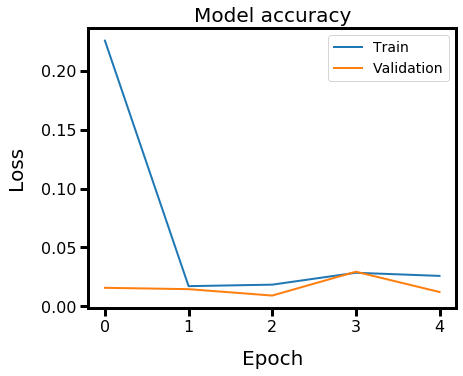

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

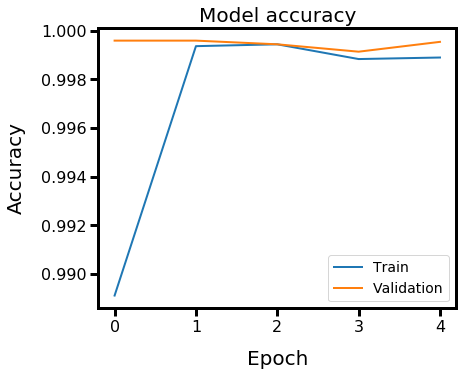

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [18]:
res_test = model.predict(X_test)
res_tc = model.predict(X_critical)

In [19]:
f_tc = int(first_tc / temp_samples)
l_tc = int(last_tc / temp_samples)

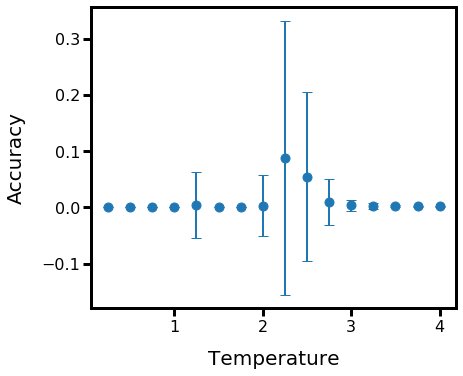

In [20]:
acc = np.zeros(temp_val.shape[0])
acc_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    if temp < temp_val[f_tc] or temp >= temp_val[l_tc]:
        
        pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
        aux = res_test[pos, 0] - Y_test[pos, 0]
        acc[idx] = np.mean(np.abs(aux))
        acc_std[idx] = np.std(np.abs(aux))
        
    else:
       
        pos = np.argwhere(Y_critical[:, 1] == temp)[:, 0]
    
        aux = res_tc[pos, 0] - Y_critical[pos, 0]
        acc[idx] = np.mean(np.abs(aux))
        acc_std[idx] = np.std(np.abs(aux))
    
    
plt.errorbar(x=temp_val, y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

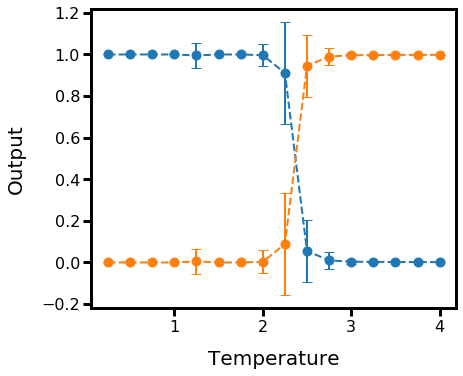

In [21]:
#%matplotlib notebook
output_mean = np.zeros(temp_val.shape[0])
output_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    if temp < temp_val[f_tc] or temp >= temp_val[l_tc]:
        
        pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
        output_mean[idx] = np.mean(res_test[pos])
        output_std[idx] = np.std(res_test[pos])
    
    else:
    
        pos = np.argwhere(Y_critical[:, 1] == temp)[:, 0]
        
        output_mean[idx] = np.mean(res_tc[pos])
        output_std[idx] = np.std(res_tc[pos])
    
    
plt.errorbar(x=temp_val, y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')

plt.errorbar(x=temp_val, y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')

plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()